# Preliminaries

In [1]:
import os.path
import datetime, time

import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(26, 26)

In [5]:
if os.path.exists("/tmp/agent_goods.log"):
    agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))
    #TODO: assumes every agent produces exactly one good
    agent_goods = agent_goods_df.idxmax(axis=1)
    loaded_agent_goods_from_file = True
else:
    loaded_agent_goods_from_file = False

## Loading Other Data

In [6]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [7]:
# if we were not able to load agent_goods_df above, infer it from sell prices now
if not loaded_agent_goods_from_file:
    g = sell_price_df.drop("tick", axis=1).groupby("agent").min()
    agent_goods_df = np.zeros((len(g),production_chain.num_products), dtype=int)
    agent_goods = np.full((len(g),), -3)
    for i in g.index:
        if g.loc[i].min() > 0:
            agent_goods_df[i,g.loc[i].argmin()] = 1
            agent_goods[i] = g.loc[i].argmin()
    agent_goods_df = pd.DataFrame(agent_goods_df)
    agent_goods = pd.Series(agent_goods)

In [8]:
production_goods = agent_goods_df @ production_chain_df.T

In [9]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [11]:
# if you want to interpret tick as datetime in stellarpunk universe
#transaction_df["tick"] += time.mktime(datetime.datetime(2234, 4, 3).timetuple())
#transaction_df["tick"] = pd.to_datetime(transaction_df["tick"], unit="s")

In [12]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [13]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [14]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [15]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [16]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,9500.0,100771.076523
1,17717.0,516019.660067
2,9190.0,138619.241152
3,6813.0,181268.731947
4,13999.0,204630.351197
5,15998.0,564678.665855
6,7481.0,197558.960829
7,1935.0,73339.080871
8,42.0,28121.414120


In [17]:
#transaction_tick_grouping = "tick"
transaction_tick_grouping = transaction_df["tick"] // (5*60)

553 transactions total


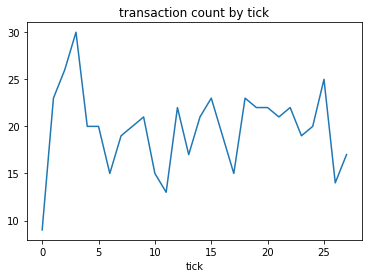

In [18]:
transaction_df.groupby(transaction_tick_grouping)["price"].count().plot()
plt.title("transaction count by tick")
print(f'{len(transaction_df)} transactions total')

Text(0.5, 1.0, 'product 0 transaction count per tick')

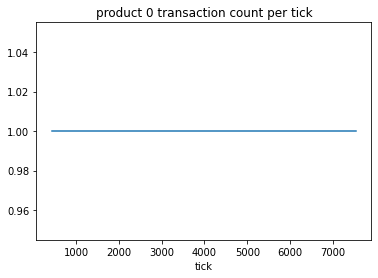

In [19]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

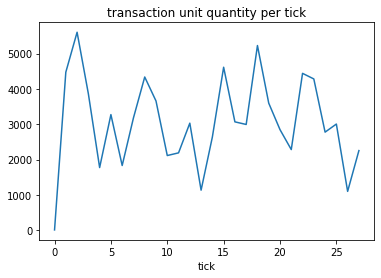

In [20]:
transaction_df.groupby(transaction_tick_grouping)["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

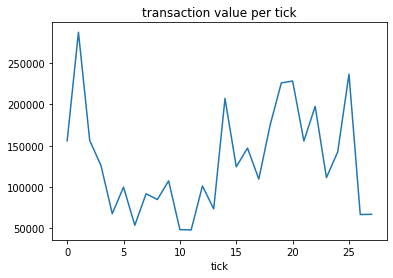

In [21]:
transaction_df.groupby(transaction_tick_grouping)["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

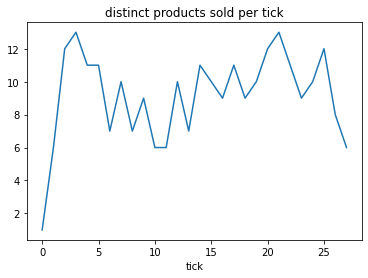

In [22]:
transaction_df.groupby(transaction_tick_grouping)["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

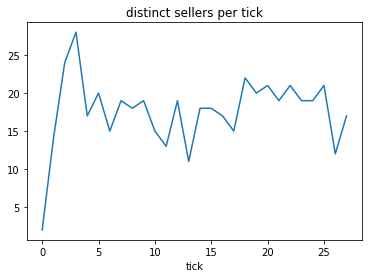

In [23]:
transaction_df.groupby(transaction_tick_grouping)["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

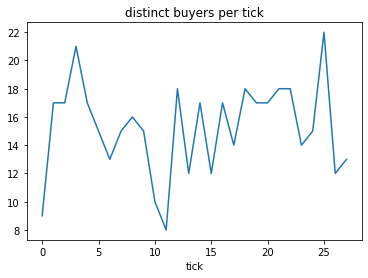

In [24]:
transaction_df.groupby(transaction_tick_grouping)["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [25]:
transaction_df["seller"].nunique()

95

In [26]:
transaction_df["buyer"].nunique()

68

In [27]:
transaction_df["product"].nunique()

22

<AxesSubplot:>

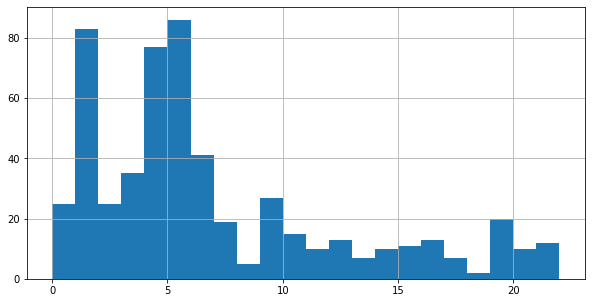

In [28]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

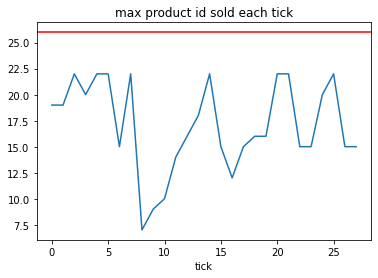

In [29]:
transaction_df.groupby(transaction_tick_grouping)["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [30]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

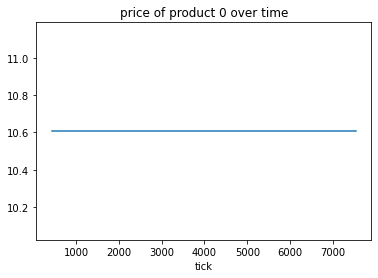

In [31]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

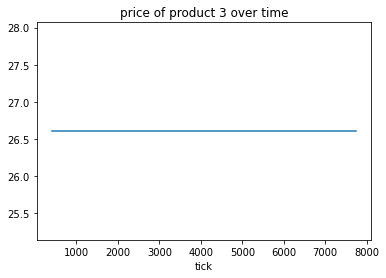

In [32]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

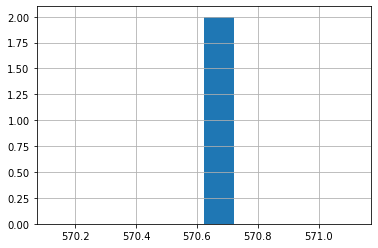

In [33]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

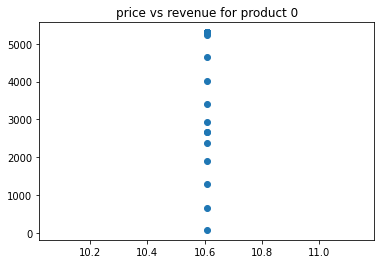

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

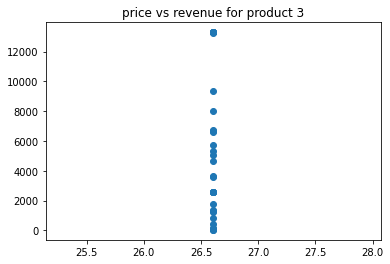

In [35]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [36]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value


In [37]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
0,7541.366667,10.607482,9500.0,100771.076523
1,8145.300000,29.125679,17717.0,516019.660067
2,7978.600000,15.083704,9190.0,138619.241152
3,7746.466667,26.606301,6813.0,181268.731947
4,8266.133333,15.107278,13999.0,204630.351197
5,8262.766667,36.868793,15998.0,564678.665855
6,7548.533333,27.787499,7481.0,197558.960829
7,7421.600000,39.323583,1935.0,73339.080871
8,8115.366667,659.317043,42.0,28121.414120


## Transaction Graph

### By Agent

In [38]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,0,95,1.0
1,1,6,561.0
2,1,17,493.0
3,1,50,178.0
4,2,26,267.0
...,...,...,...
456,100,47,31.0
457,100,51,1.0
458,100,70,7.0
459,100,71,467.0


In [39]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [40]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [41]:
G = nx.relabel_nodes(G, labels)

In [42]:
nx.is_directed_acyclic_graph(G)

False

In [43]:
# this is pretty slow for lots of agents
#plt.figure(figsize=(15, 15))
#pos = graphviz_layout(G, prog='dot')
#nx.draw(G, pos, with_labels=True, arrows=True)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()

### By Good

In [44]:

augmented_transaction_df = transaction_df.merge(agent_goods.rename("buyer_product"), how="left", left_on="buyer", right_index=True)
augmented_transaction_df["buyer_product"].fillna(-2, inplace=True)
product_flow = augmented_transaction_df.groupby(["product", "buyer_product"])["value"].sum().to_frame().reset_index().rename({"buyer_product":"target", "product":"source", "amount":"value"}, axis=1)

In [45]:
# discount intermediate sales by final sales
# this represents, e.g., traders carrying goods from one station to another
# if they completed their trade route we don't want to display that in the product flow graph
final_sales = product_flow[product_flow["target"] != -3].groupby("source")["value"].sum()
final_sales_df = pd.DataFrame(final_sales.rename("final_value")).reset_index()
final_sales_df["target"] = -3
product_flow["value"] = product_flow["value"] - product_flow.merge(final_sales_df, how="left", on=["source", "target"])["final_value"].fillna(0.)

In [46]:
set(agent_goods_df.columns) - set(product_flow["source"].unique())

{21, 23, 24, 25}

In [47]:
set(agent_goods_df.columns) - set(product_flow["target"].unique())

{0, 1, 2, 3}

In [48]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
sankey = SankeyWidget(layout=Layout(height='680', width='1024'), links=product_flow.to_dict("records"))
sankey

SankeyWidget(layout=Layout(height='680', width='1024'), links=[{'source': 0, 'target': 4, 'value': 100771.0765…

In [49]:
from IPython.display import (
    Image,
    SVG
)
import base64
data = base64.decodebytes(bytes(sankey.png, 'ascii'))
Image(data)

## Indicators by Market

In [50]:
transactions_by_product = pd.DataFrame({"producers":agent_goods_df.sum(axis=0), "sellers":transaction_df.groupby("product")["seller"].nunique()})
transactions_by_product["zero_sales"] = transactions_by_product["producers"] - transactions_by_product["sellers"]
transactions_by_product["seller_value_cv"] = transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").std() / transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").mean()
transactions_by_product["transactions"] = transaction_df.groupby("product")["price"].count()
transactions_by_product["total_amount"] = transaction_df.groupby("product")["amount"].sum()
transactions_by_product["total_value"] = transaction_df.groupby("product")["value"].sum()
transactions_by_product["price"] = transaction_df.groupby("product")["price"].mean()
transactions_by_product["price_cv"] = transaction_df.groupby("product")["price"].std() / transaction_df.groupby("product")["price"].mean()
transactions_by_product["first_tick"] = transaction_df.groupby("product")["tick"].min()
transactions_by_product["last_tick"] = transaction_df.groupby("product")["tick"].max()

transactions_by_product

,producers,sellers,zero_sales,seller_value_cv,transactions,total_amount,total_value,price,price_cv,first_tick,last_tick
0,1,13.0,-12.0,0.531118,25.0,9500.0,100771.076523,10.607482,0.000000,429.933333,7541.366667
1,0,17.0,-17.0,0.459512,83.0,17717.0,516019.660067,29.125679,0.000000,361.133333,8145.300000
2,0,13.0,-13.0,0.650743,25.0,9190.0,138619.241152,15.083704,0.000000,559.133333,7978.600000
3,0,13.0,-13.0,0.865419,35.0,6813.0,181268.731947,26.606301,0.000000,407.733333,7746.466667
4,13,31.0,-18.0,0.795118,77.0,13999.0,204630.351197,15.107278,0.183197,667.633333,8266.133333
5,9,28.0,-19.0,0.788023,86.0,15998.0,564678.665855,36.868793,0.192807,699.966667,8262.766667
6,8,19.0,-11.0,1.234644,41.0,7481.0,197558.960829,27.787499,0.224875,692.833333,7548.533333
7,4,11.0,-7.0,0.979180,19.0,1935.0,73339.080871,39.323583,0.227177,924.366667,7421.600000
8,1,3.0,-2.0,0.722578,5.0,42.0,28121.414120,659.317043,0.162409,6489.833333,8115.366667
9,2,13.0,-11.0,1.310198,27.0,1264.0,386204.575853,308.342270,0.249741,935.233333,6750.866667


Text(0.5, 1.0, 'mean prices by products')

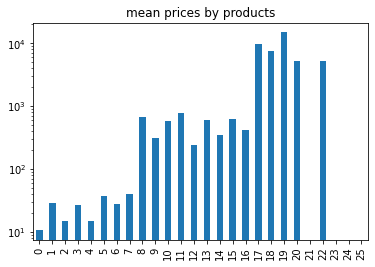

In [51]:
transactions_by_product["price"].plot.bar()
plt.yscale("log")
plt.title("mean prices by products")

Text(0.5, 1.0, 'cv by product')

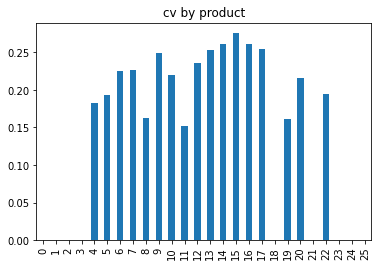

In [52]:
transactions_by_product["price_cv"].plot.bar()
plt.title("cv by product")

Text(0.5, 0.98, 'Prices for goods over time')

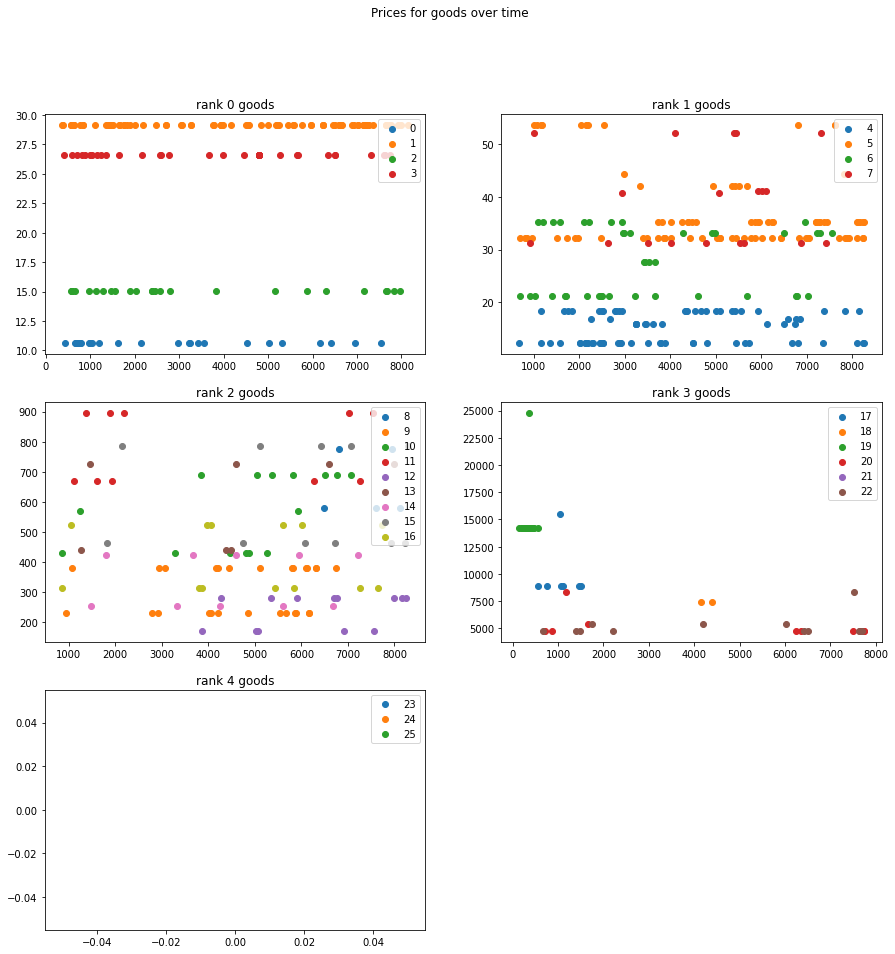

In [53]:
price_by_tick = transaction_df.groupby(["tick", "product"])["price"].mean().to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_by_tick[price_by_tick["product"] == product]["tick"], price_by_tick[price_by_tick["product"] == product]["price"], label=f'{product}')
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Prices for goods over time")

In [54]:
buy_price_melt = buy_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
buy_price_melt = buy_price_melt[buy_price_melt["price"] > 0]
buy_price_by_tick = buy_price_melt.groupby(["tick", "product"])["price"].max()
sell_price_melt = sell_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
sell_price_melt = sell_price_melt[sell_price_melt["price"] < np.inf]
sell_price_by_tick = sell_price_melt.groupby(["tick", "product"])["price"].min()

Text(0.5, 0.98, 'Buy/sell price diffs for goods over time')

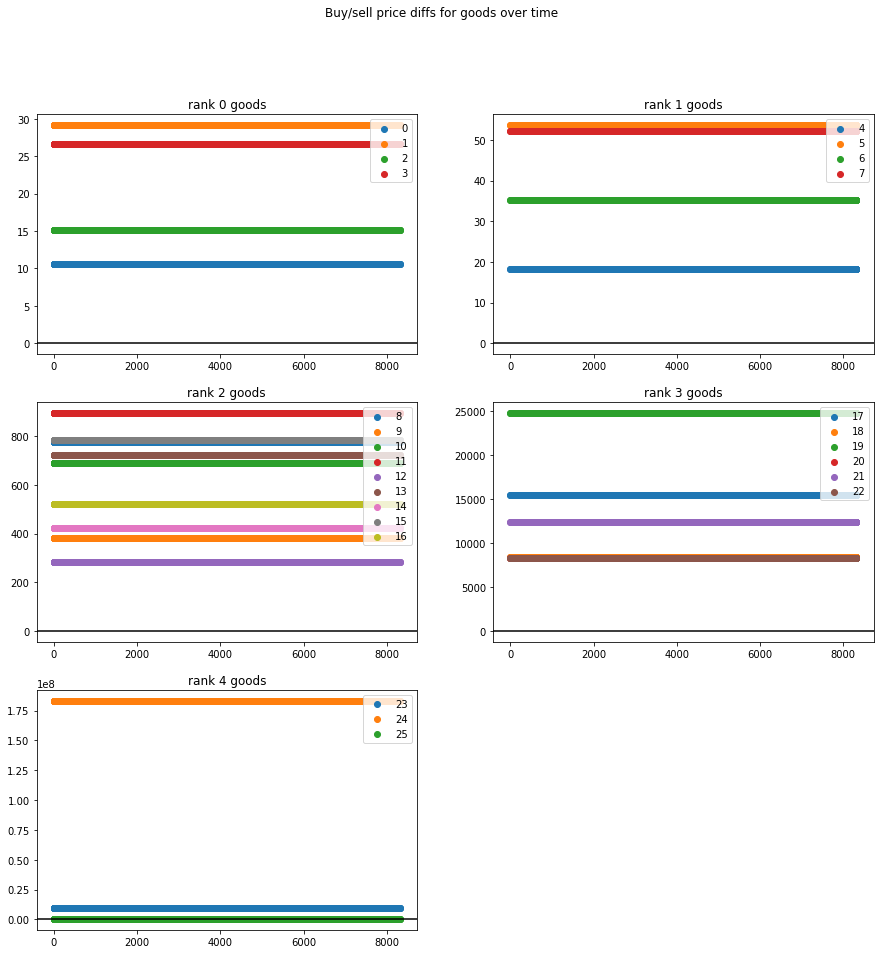

In [55]:
price_diffs = (buy_price_by_tick - sell_price_by_tick).to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_diffs[price_diffs["product"] == product]["tick"], price_diffs[price_diffs["product"] == product]["price"], label=f'{product}')
    ax.axhline(0, color="black")
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Buy/sell price diffs for goods over time")

# Balance

In [56]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0.033333,30000.0
1,0.033333,30000.0
2,0.033333,20000.0
3,0.033333,20000.0
4,0.033333,30000.0
...,...,...
97,0.033333,20000.0
98,0.033333,0.0
99,0.033333,0.0


In [57]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,8310.566667,6076.216280
1,8310.566667,6076.216280
2,8310.566667,28.591734
3,8310.566667,28.190890
4,8310.566667,21422.670902
...,...,...
97,8310.566667,2379.811098
98,8310.566667,0.000000
99,8310.566667,0.000000


In [58]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [59]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count       102.000000
mean      15196.078431
std       16767.507012
min           0.000000
25%           0.000000
50%       20000.000000
75%       30000.000000
max      110000.000000
Name: balance, dtype: float64

In [60]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count       102.000000
mean       6939.945799
std       17806.213473
min           0.000000
25%           0.000000
50%           7.601703
75%        3091.039965
max      110000.000000
Name: balance, dtype: float64

In [61]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

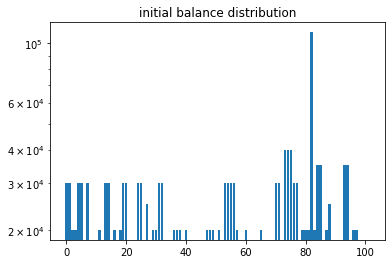

In [62]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

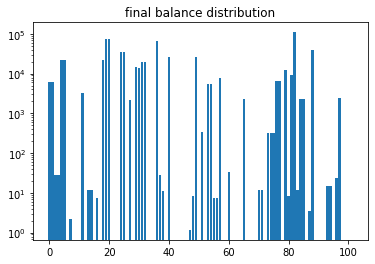

In [63]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [64]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0     -23923.783720
1     -23923.783720
2     -19971.408266
3     -19971.809110
4      -8577.329098
           ...     
97    -17620.188902
98         0.000000
99         0.000000
100        0.000000
101        0.000000
Name: balance, Length: 102, dtype: float64

<AxesSubplot:xlabel='agent'>

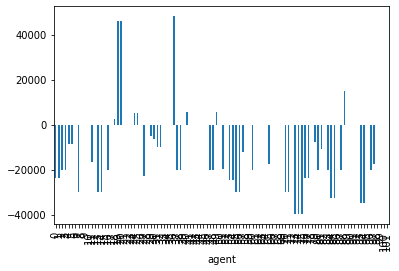

In [65]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]).plot.bar()

In [66]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0       6076.216280
1       6076.216280
2         28.591734
3         28.190890
4      21422.670902
           ...     
97      2379.811098
98         0.000000
99         0.000000
100        0.000000
101        0.000000
Name: balance, Length: 102, dtype: float64

In [67]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
420546,0,8310.566667,6076.216280
420547,1,8310.566667,6076.216280
420548,2,8310.566667,28.591734
420549,3,8310.566667,28.190890
420550,4,8310.566667,21422.670902
420551,5,8310.566667,21422.670902
420552,6,8310.566667,0.000000
420553,7,8310.566667,2.255330
420554,8,8310.566667,0.000000
420555,9,8310.566667,0.000000


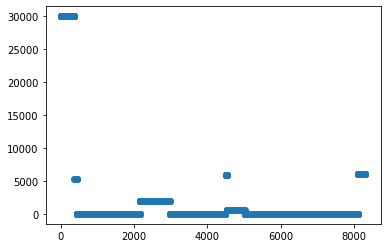

In [68]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [69]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [70]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,0.202541
1,0.202541
2,0.001430
3,0.001410
4,0.714089
...,...
97,0.118991
98,NaN
99,NaN


# Inventory

## Last Tick Inventory

In [71]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,16,17,18,19,20,21,22,23,24,25
420546,0,8310.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.0,0.0
420547,1,8310.566667,8.0,0.0,0.0,0.0,535.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420548,2,8310.566667,0.0,74.0,0.0,0.0,0.0,1004.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420549,3,8310.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0
420550,4,8310.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420643,97,8310.566667,0.0,520.0,0.0,0.0,0.0,617.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420644,98,8310.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420645,99,8310.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420646,100,8310.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [72]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,NaN
1,0.0,0.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,1004.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.0,0.0,0.0,0.0,0.0,617.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [73]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [74]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1661.0,0.0,-389.0,0.0,-1295.0,0.0,0.0,0.0,0.0,NaN
1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.0,519.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [75]:
agent_id = 22
target_tick = np.inf

target_tick = np.clip(target_tick, 0, inventory_df["tick"].max())

#inv_s = inventory_df[inventory_df["tick"] == target_tick].set_index("agent").loc[agent_id].drop("tick")
inv_s = inventory_df.drop("tick", axis=1).groupby("agent").mean().loc[agent_id]
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,0.0,NaN
9,0.0,0.0,0.0,0.0,NaN


In [76]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == target_tick)]

,agent,tick,balance
420568,22,8310.566667,0.0


In [77]:
buy_price_df[(buy_price_df["tick"] == target_tick) & (buy_price_df["agent"] == agent_id)].T

,420568
agent,22.000000
tick,8310.566667
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [78]:
buy_budget_df[(buy_budget_df["tick"] == target_tick) & (buy_budget_df["agent"] == agent_id)].T

,420568
agent,22.000000
tick,8310.566667
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [79]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    4124.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: 22, dtype: float64

# Buy and Sell Prices

In [80]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
dtype: float64

## Market Analysis for one Good

### Overview of one Market

In [81]:
product_id = 3
min_ticks = 0
max_ticks = np.inf

max_ticks = np.clip(max_ticks, 0, sell_price_df["tick"].max())

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df1_mean = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df1_max = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].max().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [82]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
6,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Buyer Prices

In [83]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
87,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
94,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
96,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301


#### Market Volume

nan


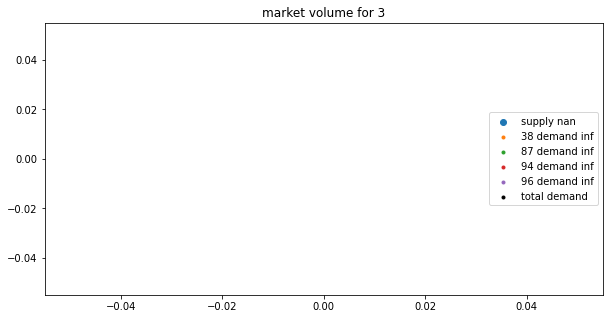

In [84]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [85]:
seller_df[seller_df > 0].index.to_series().describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: tick, dtype: float64

In [86]:
seller_df.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 3, dtype: float64

In [87]:
buyer_df.groupby("agent")["units"].describe()

/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,inf,NaN,inf,NaN,NaN,NaN,inf
87,4124.0,inf,NaN,inf,NaN,NaN,NaN,inf
94,4124.0,inf,NaN,inf,NaN,NaN,NaN,inf
96,4124.0,inf,NaN,inf,NaN,NaN,NaN,inf


In [88]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
df2[product_id].max()

26.6063014746602

In [90]:
df2.groupby("tick")[product_id].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,4124.0,4.124000e+03,4124.0,4.124000e+03,4.124000e+03,4.124000e+03,4.124000e+03,4.124000e+03
mean,4.0,2.660630e+01,0.0,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01
std,0.0,3.553144e-15,0.0,3.553144e-15,3.553144e-15,3.553144e-15,3.553144e-15,3.553144e-15
min,4.0,2.660630e+01,0.0,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01
25%,4.0,2.660630e+01,0.0,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01
50%,4.0,2.660630e+01,0.0,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01
75%,4.0,2.660630e+01,0.0,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01
max,4.0,2.660630e+01,0.0,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01,2.660630e+01


#### Market Price

is there a transaction?
do the sellers have inventory?
do any buyers demand goods?
are prices compatible?
is at least one agent in the cannot buy state (> 100 ticks)


Text(0.5, 1.0, 'price chart for 3')

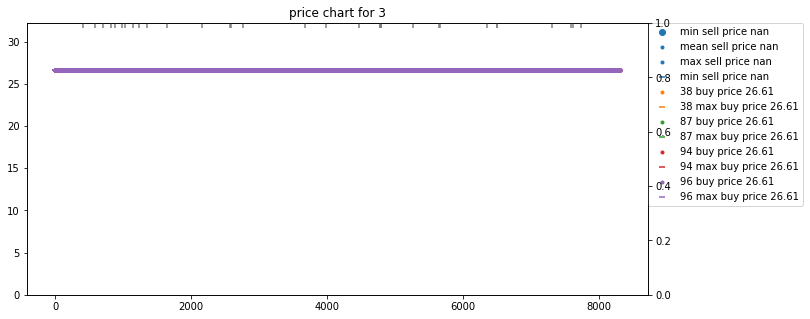

In [91]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'min sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(df1_mean.index, df1_mean[product_id], label=f'mean sell price {df1_mean[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(df1_mean.index, df1_max[product_id], label=f'max sell price {df1_max[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
if len(df2) > 0:
    plt.ylim(0, df2[product_id].max()*1.1)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
print("is there a transaction?")
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
print("do the sellers have inventory?")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
print("do any buyers demand goods?")
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
print("are prices compatible?")
price_diff = (df2.groupby("tick")[product_id].max() - df1[product_id]).rename("price_diff")
ax2.vlines(df1.join(price_diff[price_diff>0]).index, ymin=0.92, ymax=0.94, color="darkgreen")
print("is at least one agent in the cannot buy state (> 100 ticks)")
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [92]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
18,407.733333,3,87,39,26.606301,500.0,13303.150737
30,583.033333,3,87,62,26.606301,251.0,6678.181670
41,700.366667,3,38,62,26.606301,249.0,6624.969067
50,822.166667,3,38,41,26.606301,500.0,13303.150737
57,876.333333,3,38,39,26.606301,500.0,13303.150737
64,989.700000,3,38,50,26.606301,500.0,13303.150737
69,1025.233333,3,38,59,26.606301,2.0,53.212603
81,1144.266667,3,96,59,26.606301,498.0,13249.938134
89,1241.200000,3,87,78,26.606301,31.0,824.795346
93,1352.200000,3,96,78,26.606301,253.0,6731.394273


#### Ticks when max buy price changes a lot

In [93]:
def consecutive_diffs(x):
    return x.iloc[1] - x.iloc[0]
    print(x)
    raise Exception(x.__class__)
mb_diffs = dfmb.set_index("tick").groupby("agent")[product_id].rolling(2).apply(consecutive_diffs)
mb_diffs.to_frame().sort_values(["agent", product_id], key=abs, ascending=False).groupby("agent").head(5)

3
agent tick          
96    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
94    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
87    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
38    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0

#### Balance

(0.0, 36749.93729840735)

<Figure size 432x288 with 0 Axes>

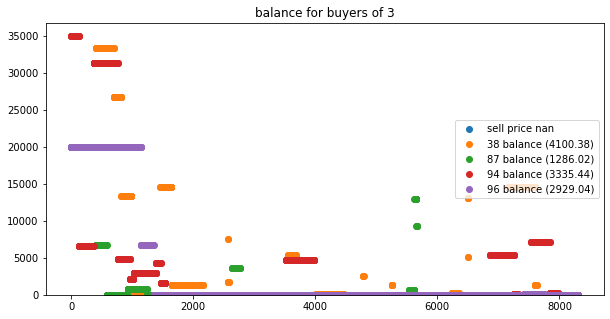

In [94]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [95]:
np.where(agent_goods_df[product_id])

(array([], dtype=int64),)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

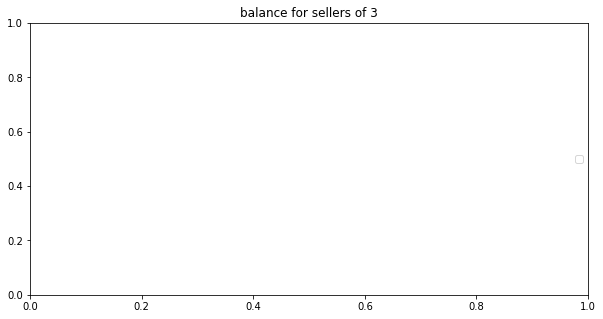

In [96]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
#plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(np.where(agent_goods_df[product_id])[0], colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for sellers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

### Sellers for the Market

In [97]:
np.where(agent_goods_df[product_id] == 1)

(array([], dtype=int64),)

Amounts Sold

In [98]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

seller
12      190.0
33       48.0
39     1500.0
41     1000.0
42       97.0
50      500.0
59     1000.0
62      500.0
63      118.0
66      500.0
78      851.0
91      503.0
101       6.0
Name: amount, dtype: float64

Time ranges of sales

In [99]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
12,1.0,6507.700000,NaN,6507.700000,6507.700000,6507.700000,6507.700000,6507.700000
33,2.0,7688.250000,82.330800,7630.033333,7659.141667,7688.250000,7717.358333,7746.466667
39,8.0,3752.870833,1924.132168,407.733333,3808.608333,4788.333333,4791.083333,4793.200000
41,2.0,4210.016667,4791.143417,822.166667,2516.091667,4210.016667,5903.941667,7597.866667
42,1.0,4794.533333,NaN,4794.533333,4794.533333,4794.533333,4794.533333,4794.533333
50,1.0,989.700000,NaN,989.700000,989.700000,989.700000,989.700000,989.700000
59,7.0,3028.623810,1745.282176,1025.233333,1652.016667,2765.066667,4224.300000,5657.433333
62,2.0,641.700000,82.967196,583.033333,612.366667,641.700000,671.033333,700.366667
63,2.0,3923.550000,1896.908221,2582.233333,3252.891667,3923.550000,4594.208333,5264.866667


Prices for transactions

In [100]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
12,1.0,26.606301,NaN,26.606301,26.606301,26.606301,26.606301,26.606301
33,2.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
39,8.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
41,2.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
42,1.0,26.606301,NaN,26.606301,26.606301,26.606301,26.606301,26.606301
50,1.0,26.606301,NaN,26.606301,26.606301,26.606301,26.606301,26.606301
59,7.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
62,2.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
63,2.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301


Desired sell prices

In [101]:
sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
6,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Min Sell Prices

In [102]:
min_sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
6,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Product inventory

In [103]:
inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max


In [104]:
for agent in np.where(agent_goods_df[product_id])[0]:
    plt.scatter(inventory_df[inventory_df["agent"] == agent]["tick"], inventory_df[inventory_df["agent"] == agent][product_id])

Input inventory

In [105]:
production_needs = pd.Series(production_chain.adj_matrix[:,product_id] * production_chain.batch_sizes[product_id])
production_needs[production_needs > 0].to_frame()

,0


In [106]:
production_needs[production_needs > 0].index.to_list()

[]

In [107]:
input_ids = production_needs[production_needs > 0].index.to_list()
inventory_melt = pd.melt(inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["agent", "tick"]+input_ids], id_vars=["agent", "tick"], value_vars=input_ids, var_name="product")
input_inventory_info = inventory_melt.groupby(["agent", "product"])["value"].describe()
input_inventory_info

,count,mean,std,min,25%,50%,75%,max


In [108]:
inventory_melt.groupby(["agent","tick"])["value"].min().groupby("agent").describe()

,count,mean,std,min,25%,50%,75%,max


Cannot sell ticks by seller

In [109]:
relevant_cannot_sell_df = cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["tick", "agent", product_id]]
relevant_cannot_sell_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'cannot sell 3')

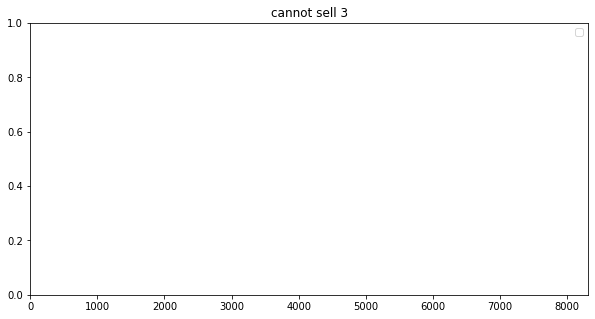

In [110]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_sell_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_sell_df[(relevant_cannot_sell_df["agent"] == agent) & (relevant_cannot_sell_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.xlim(min_ticks, max_ticks)
plt.title(f'cannot sell {product_id}')

### Buyers for the Market

Total Amount Purchased

In [111]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

buyer
38    4477.0
87    1405.0
94     179.0
96     752.0
Name: amount, dtype: float64

Time Ranges of Purchase

In [112]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
38,24.0,3954.475000,2207.539338,700.366667,2031.291667,4786.666667,4912.116667,7630.033333
87,6.0,2719.872222,2424.963890,407.733333,747.575000,2003.133333,4934.341667,5664.766667
94,2.0,5650.650000,2359.780320,3982.033333,4816.341667,5650.650000,6484.958333,7319.266667
96,3.0,3414.311111,3753.197022,1144.266667,1248.233333,1352.200000,4549.333333,7746.466667


Prices Paid

In [113]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
38,24.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
87,6.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
94,2.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301
96,3.0,26.606301,0.0,26.606301,26.606301,26.606301,26.606301,26.606301


Desired Buy Prices

In [114]:
buy_price_df[buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
87,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
94,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
96,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301


In [115]:
max_buy_price_df[max_buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
87,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
94,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
96,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301


Cannot buy ticks by buyer

In [116]:
relevant_cannot_buy_df = cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id]>0)[0])][["tick", "agent", product_id]]
relevant_cannot_buy_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,4124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Behavior of one buyer

In [117]:
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
price_diff[price_diff > 0].index

Float64Index([0.03333333333333333,   2.033333333333336,   4.066666666666662,
                6.099999999999988,   8.133333333333315,  10.166666666666641,
               12.199999999999967,  14.233333333333293,    16.2333333333333,
                 18.2333333333334,
              ...
                8292.266666714293,   8294.300000047597,     8296.3333333809,
                8298.366666714204,   8300.400000047508,   8302.433333380812,
                8304.466666714115,    8306.50000004742,   8308.533333380723,
                8310.566666714027],
             dtype='float64', name='tick', length=4124)

is transaction?
cannot buy?
has budget?
buy price at max price?
price compatible


Text(0.5, 1.0, 'behavior for buyer 38')

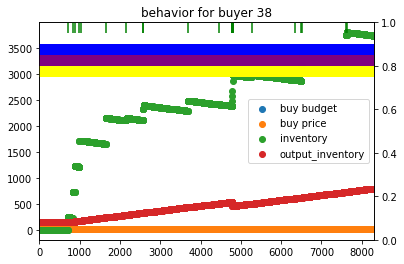

In [118]:
agent_id = relevant_cannot_buy_df["agent"].unique()[0]
agent_output = agent_goods_df.loc[agent_id].idxmax()
plt.scatter(buy_budget_df[buy_budget_df["agent"] == agent_id]["tick"], buy_budget_df[buy_budget_df["agent"] == agent_id][product_id], label=f'buy budget')
plt.scatter(buy_price_df[buy_price_df["agent"] == agent_id]["tick"], buy_price_df[buy_price_df["agent"] == agent_id][product_id], label=f'buy price')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][product_id], label=f'inventory')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][agent_output], label=f'output_inventory')
plt.legend(loc="right")
ax2 = plt.twinx()

print("is transaction?")
ax2.vlines(transaction_df[(transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]["tick"], ymin=0.95, ymax=1.0, color="green")
print("cannot buy?")
ax2.vlines(cannot_buy_df[(cannot_buy_df["agent"] == agent_id) & (cannot_buy_df[product_id] > 0)]["tick"], ymin=0.90, ymax=0.95, color="red")
print("has budget?")
ax2.vlines(buy_budget_df[(buy_budget_df["agent"] == agent_id) & (buy_budget_df[product_id] > 0)]["tick"], ymin=0.85, ymax=0.90, color="blue")
print("buy price at max price?")
ax2.vlines(buy_price_df[(buy_price_df["agent"] == agent_id) & (max_buy_price_df[product_id] - buy_price_df[product_id] < econ_sim.PRICE_EPS)]["tick"], ymin=0.80, ymax=0.85, color="purple")
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
print("price compatible")
ax2.vlines(price_diff[price_diff > 0].index, ymin=0.75, ymax=0.80, color="yellow")
ax2.set_ylim(0,1)

plt.xlim(min_ticks, max_ticks)

plt.title(f'behavior for buyer {agent_id}')

In [119]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
41,700.366667,3,38,62,26.606301,249.0,6624.969067
50,822.166667,3,38,41,26.606301,500.0,13303.150737
57,876.333333,3,38,39,26.606301,500.0,13303.150737
64,989.700000,3,38,50,26.606301,500.0,13303.150737
69,1025.233333,3,38,59,26.606301,2.0,53.212603
117,1645.866667,3,38,66,26.606301,500.0,13303.150737
149,2159.766667,3,38,59,26.606301,48.0,1277.102471
177,2570.566667,3,38,78,26.606301,216.0,5746.961119
178,2582.233333,3,38,63,26.606301,67.0,1782.622199
235,3680.466667,3,38,91,26.606301,199.0,5294.653993


<AxesSubplot:xlabel='tick'>

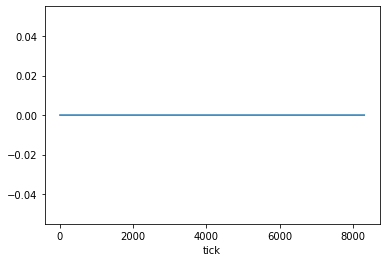

In [120]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & (cannot_buy_df["agent"] == agent_id)].set_index("tick")[product_id].plot()

When cannot buy exceeds 0

In [121]:
relevant_cannot_buy_df[relevant_cannot_buy_df[product_id] > 0].groupby("agent")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max


(0.0, 8310.566666714027)

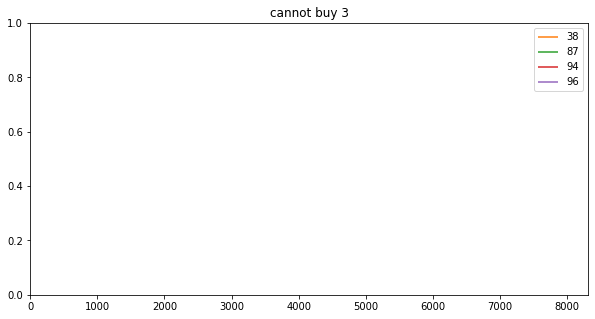

In [122]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_buy_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_buy_df[(relevant_cannot_buy_df["agent"] == agent) & (relevant_cannot_buy_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.title(f'cannot buy {product_id}')
plt.xlim(min_ticks, max_ticks)

## Buy/Sell Price Investigation

In [123]:
df1[product_id].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 3, dtype: float64

In [124]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
38,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
87,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
94,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301
96,4124.0,26.606301,3.553144e-15,26.606301,26.606301,26.606301,26.606301,26.606301


In [125]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

IndexError: single positional indexer is out-of-bounds

In [ ]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

In [ ]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

In [ ]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

In [ ]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

## Larger Scale Market Analysis

In [ ]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [ ]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

In [ ]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

In [ ]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

## Cannot Buy or Sell

In [ ]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1)

In [ ]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_buy_df["agent"].nunique())))
plt.title("distribution of max cannot buy ticks for agents")

Summary of cannot buy by good

In [ ]:
maxes = cannot_buy_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][production_goods[product] > 0].describe())
cannot_buy_summary = pd.concat(describe_series, axis=1).T
cannot_buy_summary["cv"] = cannot_buy_summary["std"] / cannot_buy_summary["mean"]
cannot_buy_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_buy_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_buy_summary

In [ ]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_sell_df["agent"].nunique())))
plt.title("distribution of max cannot sell ticks for agents")

In [ ]:
#cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[0] > 0)[0])]
cannot_sell_df[cannot_sell_df["agent"].isin([0])].set_index("tick")[0].plot()

In [ ]:
transaction_df[(transaction_df["product"] == 0) & (transaction_df["seller"] == 0)].groupby("tick")["tick"].count()

In [ ]:
cannot_sell_df[(cannot_sell_df["agent"] == 0) & (cannot_sell_df["tick"] > 46026)]

Summary of cannot sell by product

In [ ]:
maxes = cannot_sell_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][agent_goods_df[product] > 0].describe())
cannot_sell_summary = pd.concat(describe_series, axis=1).T
cannot_sell_summary["cv"] = cannot_sell_summary["std"] / cannot_sell_summary["mean"]
cannot_sell_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_sell_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_sell_summary

# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [ ]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [ ]:
costs.describe()

In [ ]:
revenue.describe()

Profit (without accounting for inventory value):

In [ ]:
(revenue-costs).describe()

In [ ]:
((revenue - costs)).hist(bins=int(np.sqrt(revenue.shape[0])))

How much value is sitting in inventory?

In [ ]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

In [ ]:
revenue.mean() - costs.mean()

In [ ]:
value_of_goods_on_hand.mean()/revenue.mean()

Profit (accounting for value of goods on hand):

In [ ]:
((revenue - costs) + value_of_goods_on_hand).describe()

In [ ]:
((revenue - costs) + value_of_goods_on_hand).hist(bins=int(np.sqrt(revenue.shape[0])))

## Further Investigation

### Profit by Product

In [ ]:
revenue-costs

In [ ]:
agent_results = pd.DataFrame({"product":agent_goods, "profit":revenue-costs})
profit_by_product = agent_results.groupby("product")["profit"].describe().sort_values("mean")
profit_by_product["sem"] = agent_results.groupby("product").sem()
profit_by_product = profit_by_product.sort_values("mean", ascending=False)
profit_by_product

In [ ]:
plt.scatter(profit_by_product["count"], profit_by_product["mean"])
plt.xscale("log")
plt.yscale("symlog")

In [ ]:
xvals = np.arange(len(profit_by_product))
width = 0.2
plt.bar(list(map(lambda x: f'product {x}', profit_by_product.index.to_list())), profit_by_product["mean"], yerr=profit_by_product["sem"].fillna(0))
#ax2 = plt.twinx()
#ax2.bar(xvals + width, profit_by_product["std"], width=width)

### Who Made a Profit?

In [ ]:
print(len(np.where(((revenue - costs)) > 0)[0]))
np.where(((revenue - costs)) > 0)

In [ ]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) > 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

In [ ]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

In [ ]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

top profit takers

In [ ]:
(revenue-costs).sort_values(ascending=False).head(20)

In [ ]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

Taking into account value of goods on hand:

In [ ]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

In [ ]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

### Who Made a Loss?

And selling what products?

In [ ]:
print(len(np.where(((revenue - costs)) < 0)[0]))
np.where(((revenue - costs)) < 0)

In [ ]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) < 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

In [ ]:
(revenue-costs).sort_values(ascending=True).head(20)

In [ ]:
agent_goods_df[((revenue - costs)) < 0].idxmax(axis=1).head(20)

In [ ]:
(revenue-costs + value_of_goods_on_hand).sort_values(ascending=True).head(20)

In [ ]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

## Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [ ]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

In [ ]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

In [ ]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

## Profit By Prices

In [ ]:
production_goods

In [ ]:
(buy_price_df[buy_price_df["agent"] == 26].drop(["agent", "tick"], axis=1) * production_goods.loc[26]).sum(axis=1).plot()

In [ ]:
sell_price_df[sell_price_df["agent"] == 26][26].plot()

# Production Efficiency